# Modelling a Pandemic across an Airline Network

In [1]:
# importing some pretty standard libraries
import pandas as pd
import numpy as np
import networkx as nx
import random

random_seed = 5432
random.seed(random_seed)

In [2]:
# reading in the data from OpenFlights: https://github.com/jpatokal/openflights
airports_df = pd.read_csv('https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat',
    names=['Airport ID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude', 'Altitude',
        'Timezone', 'DST', 'Tz database time zone', 'Type', 'Source'], index_col=0)

airlines_df = pd.read_csv('https://raw.githubusercontent.com/jpatokal/openflights/master/data/airlines.dat',
    names=['Airline ID', 'Name', 'Alias', 'IATA', 'ICAO', 'Callsign', 'Country', 'Active'], index_col=0)

routes_df = pd.read_csv('https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat',
    names=['Airline', 'Airline ID', 'Source airport', 'Source airport ID', 'Destination airport',
        'Destination airport ID', 'Codeshare', 'Stops', 'Equipment'])

planes_df = pd.read_csv('https://raw.githubusercontent.com/jpatokal/openflights/master/data/planes.dat',
    names=['Name', 'IATA code', 'ICAO code'])

# dealing with missing values
airlines_df = airlines_df.fillna('').replace({r'\N': None})
routes_df = routes_df.fillna('').replace({r'\N': None})
planes_df = planes_df.replace({r'\N': None})
airports_df = airports_df.replace({r'\N': None})

# dropping irrelevant columns
drop_cols = ['Latitude', 'Longitude', 'Altitude', 'Timezone', 'DST', 'Tz database time zone', 'Type', 'Source', 'ICAO']
airports_df = airports_df.drop(drop_cols, axis=1, errors='ignore').dropna()

# ensure routes and airports all correspond to each other
routes_df = routes_df[(routes_df['Destination airport'].isin(airports_df['IATA'])) & (routes_df['Source airport'].isin(airports_df['IATA']))]
airports_df = airports_df[(airports_df['IATA'].isin(routes_df['Source airport'])) | (airports_df['IATA'].isin(routes_df['Destination airport']))]

In [3]:
# Let's build the graph!
G = nx.MultiDiGraph()
G.add_nodes_from(airports_df['IATA'])
edge_list = [(r[0], r[1], random.randint(1, 3)*5) for r in routes_df[['Source airport', 'Destination airport']].to_records(index=False)]
G.add_weighted_edges_from(edge_list)
airports_df['out_degree'] = airports_df.apply(lambda x: G.out_degree[x['IATA']], axis=1)
airports_df['in_degree'] = airports_df.apply(lambda x: G.in_degree[x['IATA']], axis=1)
airports_df['weighted_out_degree'] = airports_df.apply(lambda x: sum(e[2]['weight'] for e in G.edges(x['IATA'], data=True)), axis=1)
airports_df['weighted_in_degree'] = airports_df.apply(lambda x: sum(e[2]['weight'] for e in G.in_edges(x['IATA'], data=True)), axis=1)
airports_df

,Name,City,Country,IATA,out_degree,in_degree,weighted_out_degree,weighted_in_degree
Airport ID,,,,,,,,
1,Goroka Airport,Goroka,Papua New Guinea,GKA,5,5,45,45
2,Madang Airport,Madang,Papua New Guinea,MAG,8,8,80,65
3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,10,12,115,90
4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,11,11,120,115
5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,49,48,490,495
...,...,...,...,...,...,...,...,...
13754,La Araucanía Airport,Temuco,Chile,ZCO,3,3,30,30
13760,New Islamabad International Airport,Islamabad,Pakistan,ISB,58,59,525,625
14095,Songwe Airport,Mbeya,Tanzania,MBI,1,1,10,10


## Simulation Steps
1. Passengers at each airport are randomly assigned to an outgoing flight until all outgoing flight seats are full.
2. Passengers interact with `num_airplane_people_interactions` other random people and healthy passengers have an `airplane_p_spread` chance of being infected after interacting with an infected person.
3. Passengers arive at their destination.
4. At each airport, some proportion of random people (specified by `p_leave_airport`) leave the airport.
5. Remaining passengers interact with `num_airport_people_interactions` other random people. Healthy passengers have an `airport_p_spread` chance of being infected after interacting with an infected person.
6. At each airport:
    - If there are more people than outgoing flight capacity, a random number of people leave until the number of people matches the outgoing flight capacities.
    - If there are less people than outgoing flight capacity, new healthy passengers arrive until the number of people matches the outgoing flight capacities.
7. Steps 1-6 repeat `num_iterations` times.

In [62]:
num_iterations = 40

num_airport_people_interactions = 10
airport_p_spread = .05

num_airplane_people_interactions = 2
airplane_p_spread = .2

p_leave_airport = .2

people_states = {d['IATA'] : [d['weighted_out_degree']]+[0]*num_iterations for d in airports_df.to_dict('records')}
infected_states = {k: [0]*(num_iterations+1) for k in people_states}
num_infected_in_transit_states = {k: [-1] + [0]*(num_iterations) for k in people_states}
num_infected_upon_landing_states = {k: [-1] + [0]*(num_iterations) for k in people_states}

# Initial infections
infected_states['HSV'][0] = 5

In [63]:
def divide_infected_among_routes(num_infected, route_capacities):
    out = [0]*len(route_capacities)
    cum = np.cumsum(route_capacities)

    # check for if everyone is already infected
    if num_infected >= cum[-1]:
        return route_capacities

    while num_infected > 0:
        i = np.searchsorted(cum, random.random()*cum[-1])
        if out[i] < route_capacities[i]:
            out[i] += 1
            num_infected -= 1

    return out

regular_graphs = {}

def get_num_new_infected(num_people, num_infected, num_interactions, p_spread):
    if not regular_graphs.get((num_people, num_interactions)):
        regular_graphs[(num_people, num_interactions)] = nx.random_regular_graph(d=num_interactions, n=num_people)
    
    l = random.sample(range(num_people), k=num_people)
    interaction_graph = nx.relabel_nodes(regular_graphs[(num_people, num_interactions)], lambda x: l[x])
    return sum(random.random() > (1-p_spread)**sum(map(lambda x: x < num_infected, interaction_graph.neighbors(i))) for i in range(num_infected, num_people))

In [64]:
for t in range(num_iterations):
    # travel stage
    for airport in people_states:
        this_stage_infected = infected_states[airport][t]

        routes_list = list(G.out_edges(airport, data=True))
        if len(routes_list) <= 0:
            continue
        else:
            route_capacities = [r[2]['weight'] for r in routes_list]
            divided_infected = divide_infected_among_routes(num_infected=this_stage_infected, route_capacities=route_capacities)
        
        for route, capacity, num_infected in zip(routes_list, route_capacities, divided_infected):
            num_infected_in_transit = get_num_new_infected(num_people=capacity, num_infected=num_infected, num_interactions=num_airplane_people_interactions, p_spread=airplane_p_spread)
            # people arrive at destination
            people_states[route[1]][t+1] += capacity
            num_infected_in_transit_states[route[1]][t+1] += num_infected_in_transit
            infected_states[route[1]][t+1] += num_infected + num_infected_in_transit

    for airport in people_states:
        if people_states[airport][t+1] > 0:
            # people leave the airport
            people_states[airport][t+1] = np.sum(np.random.random_sample(people_states[airport][t+1] - infected_states[airport][t+1]) > p_leave_airport)
            infected_states[airport][t+1] = np.sum(np.random.random_sample(infected_states[airport][t+1]) > p_leave_airport)
            people_states[airport][t+1] += infected_states[airport][t+1]
            if people_states[airport][t+1] <= 0:
                continue

            # infections at airport
            num_interactions = min(num_airport_people_interactions, people_states[airport][t+1]-1)
            num_infected_upon_landing_states[airport][t+1] = get_num_new_infected(num_people=people_states[airport][t+1], num_infected=infected_states[airport][t+1], num_interactions=num_interactions, p_spread=airport_p_spread)
            infected_states[airport][t+1] += num_infected_upon_landing_states[airport][t+1]

        # re-adjust number of people at each airport
        if people_states[airport][t+1] <= people_states[airport][0]:
            people_states[airport][t+1] = people_states[airport][0]
        else:
            num_leaving = people_states[airport][t+1] - people_states[airport][0]
            num_infected_leaving = sum(random.sample([i < infected_states[airport][t+1] for i in range(people_states[airport][t+1])], k=num_leaving))
            infected_states[airport][t+1] -= num_infected_leaving
            people_states[airport][t+1] -= num_leaving

    print(f'iteration {t} complete.')

iteration 0 complete.
iteration 1 complete.
iteration 2 complete.
iteration 3 complete.
iteration 4 complete.
iteration 5 complete.
iteration 6 complete.
iteration 7 complete.
iteration 8 complete.
iteration 9 complete.
iteration 10 complete.
iteration 11 complete.
iteration 12 complete.
iteration 13 complete.
iteration 14 complete.
iteration 15 complete.
iteration 16 complete.
iteration 17 complete.
iteration 18 complete.
iteration 19 complete.
iteration 20 complete.
iteration 21 complete.
iteration 22 complete.
iteration 23 complete.
iteration 24 complete.
iteration 25 complete.
iteration 26 complete.
iteration 27 complete.
iteration 28 complete.
iteration 29 complete.
iteration 30 complete.
iteration 31 complete.
iteration 32 complete.
iteration 33 complete.
iteration 34 complete.
iteration 35 complete.
iteration 36 complete.
iteration 37 complete.
iteration 38 complete.
iteration 39 complete.


In [65]:
infected_df = pd.DataFrame(infected_states).T
infected_df.index.rename('airport', inplace=True)
infected_df

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
airport,,,,,,,,,,,,,,,,,,,,,
GKA,0,0,0,0,0,0,0,0,0,0,...,23,27,26,28,27,21,24,21,20,28
MAG,0,0,0,0,0,0,0,0,0,0,...,45,34,40,34,46,42,36,37,38,42
HGU,0,0,0,0,0,0,0,0,0,0,...,57,54,61,48,44,67,57,44,50,57
LAE,0,0,0,0,0,0,0,0,0,0,...,68,72,67,76,73,66,64,76,72,74
POM,0,0,0,0,0,0,0,0,0,0,...,276,300,297,319,290,301,290,285,303,322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZCO,0,0,0,0,0,0,0,0,0,0,...,21,19,19,19,11,19,23,25,15,17
ISB,0,0,0,0,0,0,0,0,0,0,...,424,400,396,408,409,389,385,403,407,389
MBI,0,0,0,0,0,0,0,0,0,0,...,5,5,7,8,7,9,9,5,6,5


In [66]:
infected_intransit_df = pd.DataFrame(num_infected_in_transit_states).T
infected_intransit_df.index.rename('airport', inplace=True)
infected_intransit_df

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
airport,,,,,,,,,,,,,,,,,,,,,
GKA,-1,0,0,0,0,0,0,0,0,0,...,3,4,2,5,2,7,4,6,1,4
MAG,-1,0,0,0,0,0,0,0,0,0,...,6,7,7,9,9,3,6,5,6,6
HGU,-1,0,0,0,0,0,0,0,0,0,...,5,8,3,5,9,9,7,4,8,6
LAE,-1,0,0,0,0,0,0,0,0,0,...,9,7,7,10,9,10,4,6,11,16
POM,-1,0,0,0,0,0,0,0,0,0,...,36,50,48,37,38,40,42,38,34,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZCO,-1,0,0,0,0,0,0,0,0,0,...,2,1,1,2,0,3,4,0,1,3
ISB,-1,0,0,0,0,0,0,0,0,0,...,45,50,38,55,47,56,52,48,37,31
MBI,-1,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,2,0,1,0,1


In [67]:
num_infected_upon_landing_states = pd.DataFrame(num_infected_upon_landing_states).T
num_infected_upon_landing_states.index.rename('airport', inplace=True)
num_infected_upon_landing_states

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
airport,,,,,,,,,,,,,,,,,,,,,
GKA,-1,0,0,0,0,0,0,0,0,0,...,2,4,5,2,2,2,3,3,5,7
MAG,-1,0,0,0,0,0,0,0,0,0,...,6,5,5,2,3,4,3,3,2,7
HGU,-1,0,0,0,0,0,0,0,0,0,...,5,6,10,5,5,3,10,9,6,4
LAE,-1,0,0,0,0,0,0,0,0,0,...,8,14,7,9,12,2,11,11,10,10
POM,-1,0,0,0,0,0,0,0,0,0,...,39,34,33,31,34,30,40,36,30,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZCO,-1,0,0,0,0,0,0,0,0,0,...,3,1,4,3,1,2,3,5,2,7
ISB,-1,0,0,0,0,0,0,0,0,0,...,49,35,48,47,45,47,42,43,41,47
MBI,-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,2


In [68]:
for k in infected_states:
    if infected_states[k][4] > 0:
        print(k, infected_states[k])

ADD [0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 4, 0, 2, 4, 5, 9, 7, 19, 41, 31, 84, 102, 242, 279, 319, 443, 513, 564, 611, 577, 649, 617, 598, 616, 640, 625, 613, 657, 635, 633, 664]
MGA [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 2, 6, 22, 13, 13, 31, 51, 63, 48, 83, 80, 91, 95, 91, 95, 95, 85, 97, 95, 105, 87, 109, 117, 98, 96]
TPE [0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 5, 0, 16, 13, 26, 33, 49, 80, 148, 227, 378, 550, 734, 939, 1203, 1363, 1476, 1573, 1655, 1704, 1672, 1675, 1621, 1705, 1687, 1674, 1668, 1676, 1663, 1692]
NRT [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 3, 16, 6, 19, 28, 46, 77, 94, 210, 266, 450, 611, 829, 1069, 1242, 1481, 1581, 1697, 1699, 1836, 1814, 1858, 1823, 1811, 1854, 1780, 1813, 1837, 1834, 1840]
WUH [0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 1, 2, 9, 8, 5, 5, 29, 46, 65, 101, 172, 265, 330, 505, 613, 781, 945, 1028, 1056, 1027, 1157, 1148, 1137, 1169, 1134, 1133, 1176, 1169, 1145, 1136, 1146]
HGH [0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 4, 1, 6, 3, 24, 18, 34, 40, 93, 150, 223, 375, 537, 727, 930,

In [69]:
total_population = sum((people_states[p][0] for p in people_states))
total_population

668875

Total Population: 668875
[5, 8, 12, 18, 25, 32, 62, 112, 185, 304, 472, 748, 1214, 2074, 3526, 5814, 9662, 15782, 25426, 40518, 63696, 96736, 140161, 192536, 247835, 299529, 340535, 370357, 390295, 402344, 410210, 414514, 416473, 417392, 419109, 418725, 418795, 419215, 419534, 419626, 420599]


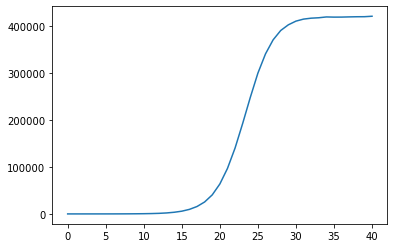

In [70]:
import matplotlib.pyplot as plt
total_population = sum((people_states[p][0] for p in people_states))
print('Total Population:', total_population)

total_infected = [sum((infected_states[i][t] for i in infected_states)) for t in range(num_iterations+1)]
print(total_infected)
plt.plot(total_infected)

[1, 3, 7, 6, 14, 15, 27, 42, 76, 111, 183, 233, 323, 421, 625, 790, 1075, 1317, 1654, 1916, 2191, 2464, 2700, 2863, 2959, 3053, 3101, 3144, 3149, 3159, 3163, 3158, 3174, 3164, 3162, 3166, 3169, 3163, 3170, 3168, 3161]


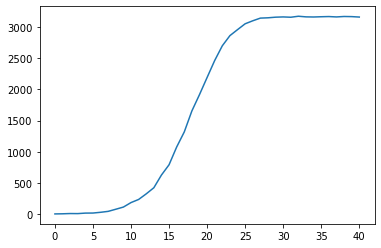

In [71]:
total_airports_infected = [sum((infected_states[i][t] > 0 for i in infected_states)) for t in range(num_iterations+1)]
print(total_airports_infected)
plt.plot(total_airports_infected)